<a href="https://colab.research.google.com/github/upayuryeva/Deep-Learning-course-HSE-/blob/main/week6/captioning_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://cdn-images-1.medium.com/max/716/1*vzFwXFJOrg6WRGNsYYT6qg.png)
_image [source](https://towardsdatascience.com/image-captioning-in-deep-learning-9cd23fb4d8d2)_



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.

### Data preprocessing

In [2]:
!wget https://www.dropbox.com/s/zl9wy31p6r05j34/handout.tar.gz -O handout.tar.gz
!tar xzf handout.tar.gz

--2021-10-31 19:26:58--  https://www.dropbox.com/s/zl9wy31p6r05j34/handout.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zl9wy31p6r05j34/handout.tar.gz [following]
--2021-10-31 19:26:59--  https://www.dropbox.com/s/raw/zl9wy31p6r05j34/handout.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc15793405e7b7c6dff38d93a9e8.dl.dropboxusercontent.com/cd/0/inline/BZGMXW1rVgwsemFea-cSCff4n-xZOf26Jzc50VrOZB5ises72SD5z8df-mahynM0J45JhwvIUc2ZF7bSumQFJbiLPEBl5IrJ4-QxEQRGtIp_r7syUEi_VXcZ0FvYr979L1Tf4SX-9k2UwDF3x5HHLc7o/file# [following]
--2021-10-31 19:26:59--  https://uc15793405e7b7c6dff38d93a9e8.dl.dropboxusercontent.com/cd/0/inline/BZGMXW1rVgwsemFea-cSCff4n-xZOf26Jzc50VrOZB5ises72SD5z8df-mahynM0J45JhwvIUc2ZF7bSumQF

In [3]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 223 ms, sys: 435 ms, total: 658 ms
Wall time: 660 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [4]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [5]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [6]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i][1:-1]:
          word_counts[word] += 1

In [7]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [9]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [11]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units).cuda()
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units).cuda()
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx = pad_ix).cuda()
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(batch_first = True, input_size=emb_size, hidden_size=lstm_units).cuda()
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens).cuda()
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, (cell_next, hid_next) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [12]:
network = CaptionNet(n_tokens)

In [13]:
dummy_img_vec = torch.randn(len(captions[0]), 2048).cuda()
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64).cuda()

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [14]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    next_reshaped = captions_ix_next.cuda().view(-1)
    logits_reshaped = logits_for_next.cuda().view(-1, logits_for_next.size()[-1])
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    cross_entropy = nn.CrossEntropyLoss(reduction = 'none').cuda()
    loss = cross_entropy(logits_reshaped, next_reshaped).view(captions_ix_next.size()[0], captions_ix_next.size()[1])
    loss = loss.mean(dim = -1).mean(dim = -1).view(-1)
    
    return loss

In [15]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.cpu().data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [16]:
opt = torch.optim.Adam(network.parameters(), lr=1e-3)

# Training

* First implement the batch generator
* Than train the network as usual

In [17]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [18]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).cuda(), torch.tensor(batch_captions_ix, dtype=torch.int64).cuda()
    

In [19]:
generate_batch(img_codes,captions,3)

(tensor([[0.1028, 0.1552, 0.1137,  ..., 0.4632, 0.3993, 0.3904],
         [0.1152, 0.2109, 0.1464,  ..., 0.0069, 1.2458, 0.2960],
         [0.9076, 0.6996, 0.4065,  ..., 0.2769, 0.3919, 0.2824]],
        device='cuda:0'),
 tensor([[   1,   24,   21,  662, 1756,    6,  716,    6,   24,  369,   12,    2,
             3,    3],
         [   1,   45,   57,   41, 2625,   45,  169,  163, 1025,  170,  175,  176,
            12,    2],
         [   1,   24,  500,   41,   38,  459,   24,  663, 3223,   12,    2,    3,
             3,    3]], device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [20]:
batch_size = 128  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 200  # adjust me
n_validation_batches = 10  # how many batches are used for validation after each epoch

In [21]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss += loss_t.cpu().detach().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.cpu().detach().numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 200/200 [00:11<00:00, 17.49it/s]



Epoch: 0, train loss: [2.848775], val loss: [2.2530408]


100%|██████████| 200/200 [00:11<00:00, 17.69it/s]



Epoch: 1, train loss: [2.0377662], val loss: [1.7848618]


100%|██████████| 200/200 [00:11<00:00, 17.97it/s]



Epoch: 2, train loss: [1.840821], val loss: [1.9662817]


100%|██████████| 200/200 [00:11<00:00, 17.10it/s]



Epoch: 3, train loss: [1.6577148], val loss: [1.7622293]


100%|██████████| 200/200 [00:11<00:00, 17.58it/s]



Epoch: 4, train loss: [1.5936154], val loss: [1.5708753]


100%|██████████| 200/200 [00:11<00:00, 17.61it/s]



Epoch: 5, train loss: [1.5529845], val loss: [1.599735]


100%|██████████| 200/200 [00:11<00:00, 17.31it/s]



Epoch: 6, train loss: [1.482029], val loss: [1.4895675]


100%|██████████| 200/200 [00:10<00:00, 18.20it/s]



Epoch: 7, train loss: [1.5078319], val loss: [1.5228175]


100%|██████████| 200/200 [00:11<00:00, 17.37it/s]



Epoch: 8, train loss: [1.4114157], val loss: [1.5360762]


100%|██████████| 200/200 [00:11<00:00, 17.16it/s]



Epoch: 9, train loss: [1.3856931], val loss: [1.4092267]


100%|██████████| 200/200 [00:11<00:00, 17.40it/s]



Epoch: 10, train loss: [1.3851794], val loss: [1.4975091]


100%|██████████| 200/200 [00:11<00:00, 17.58it/s]



Epoch: 11, train loss: [1.3787962], val loss: [1.2692736]


100%|██████████| 200/200 [00:11<00:00, 17.60it/s]



Epoch: 12, train loss: [1.360388], val loss: [1.5338867]


100%|██████████| 200/200 [00:11<00:00, 17.65it/s]



Epoch: 13, train loss: [1.3537507], val loss: [1.2734843]


100%|██████████| 200/200 [00:11<00:00, 16.84it/s]



Epoch: 14, train loss: [1.3055843], val loss: [1.283497]


100%|██████████| 200/200 [00:11<00:00, 17.41it/s]



Epoch: 15, train loss: [1.3102853], val loss: [1.3729329]


100%|██████████| 200/200 [00:11<00:00, 17.71it/s]



Epoch: 16, train loss: [1.3178729], val loss: [1.4132527]


100%|██████████| 200/200 [00:11<00:00, 17.86it/s]



Epoch: 17, train loss: [1.3332809], val loss: [1.436377]


100%|██████████| 200/200 [00:11<00:00, 17.46it/s]



Epoch: 18, train loss: [1.2949322], val loss: [1.3007139]


100%|██████████| 200/200 [00:11<00:00, 17.38it/s]



Epoch: 19, train loss: [1.2861463], val loss: [1.423149]


100%|██████████| 200/200 [00:11<00:00, 17.55it/s]



Epoch: 20, train loss: [1.2911859], val loss: [1.2020767]


100%|██████████| 200/200 [00:11<00:00, 17.89it/s]



Epoch: 21, train loss: [1.2959256], val loss: [1.4019496]


100%|██████████| 200/200 [00:11<00:00, 17.76it/s]



Epoch: 22, train loss: [1.2932234], val loss: [1.3215479]


100%|██████████| 200/200 [00:11<00:00, 17.88it/s]



Epoch: 23, train loss: [1.2787231], val loss: [1.3666897]


100%|██████████| 200/200 [00:11<00:00, 18.05it/s]



Epoch: 24, train loss: [1.2955844], val loss: [1.2842338]


100%|██████████| 200/200 [00:11<00:00, 17.28it/s]



Epoch: 25, train loss: [1.2415192], val loss: [1.1346085]


100%|██████████| 200/200 [00:11<00:00, 17.75it/s]



Epoch: 26, train loss: [1.2631152], val loss: [1.3879266]


100%|██████████| 200/200 [00:11<00:00, 17.96it/s]



Epoch: 27, train loss: [1.2762423], val loss: [1.2638505]


100%|██████████| 200/200 [00:11<00:00, 17.38it/s]



Epoch: 28, train loss: [1.2310578], val loss: [1.1447397]


100%|██████████| 200/200 [00:11<00:00, 17.94it/s]



Epoch: 29, train loss: [1.2647758], val loss: [1.2919123]


100%|██████████| 200/200 [00:11<00:00, 17.61it/s]



Epoch: 30, train loss: [1.2397751], val loss: [1.1739159]


 92%|█████████▏| 183/200 [00:10<00:00, 17.38it/s]


KeyboardInterrupt: ignored

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [22]:
!wget https://raw.githubusercontent.com/dmitrii-davidov/ysda-deep-learning/spring2019/homework04/beheaded_inception3.py

--2021-10-31 19:33:55--  https://raw.githubusercontent.com/dmitrii-davidov/ysda-deep-learning/spring2019/homework04/beheaded_inception3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1776 (1.7K) [text/plain]
Saving to: ‘beheaded_inception3.py.2’

beheaded_inception3 100%[===================>]   1.73K  --.-KB/s    in 0s      

2021-10-31 19:33:56 (15.4 MB/s) - ‘beheaded_inception3.py.2’ saved [1776/1776]



In [23]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [33]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    vectors_neck = vectors_neck.cuda()
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).cuda()
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).cpu().data.numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [25]:
!pip install scipy==1.1.0

In [27]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2021-10-31 19:34:24--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-10-31 19:34:24--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2021-10-31 19:34:24 (4.96 MB/s) - ‘data/img.jpg’ sa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


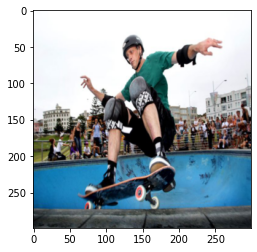

In [28]:
plt.imshow(img)

In [34]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man jumping off a skateboard in the air .
a man riding a skateboard down a ramp .
a man on a skateboard jumping over a ramp .
a man riding a skateboard on top of a ramp .
a man on a skateboard jumping over a ramp .
a person on a skateboard doing a trick on a ramp .
a man doing a trick on a skateboard on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp on a skateboard .
a man riding a skateboard down a ramp .


--2021-10-31 19:46:22--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-10-31 19:46:22--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K  --.-KB/s    in 0.01s   

2021-10-31 19:46:22 (9.27 MB/s) - ‘data/img.jpg’ saved [106870/106870]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


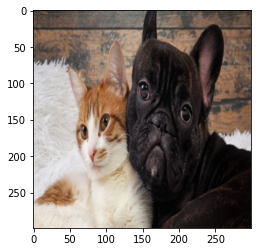

a black and white cat laying on a bed .
a cat is sitting on a chair in front of a tv .
a cat sitting on a chair with a dog in its mouth .
a cat is sitting on a chair in a room .
a black and white cat laying on a bed .
a cat sitting on the ground with a dog in its mouth .
a cat is sitting on a chair in a room .
a black cat is sitting on a chair .
a black cat sitting on a chair with a dog .
a black and white cat laying on a bed .


In [39]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [ ]:
#apply your network on image sample you found
#
#

In [36]:
def print_captions(img_name):
  img = plt.imread(img_name)
  img = imresize(img, (299, 299)).astype('float32') / 255.

  plt.imshow(img)
  plt.show()

  for i in range(10):
      print(' '.join(generate_caption(img, t=5.)[1:-1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


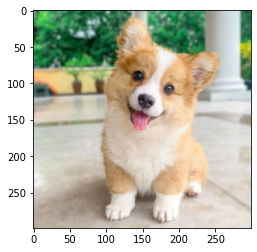

a small dog sitting on top of a bed .
a dog sitting on a bed with a dog on the floor .
a small dog sitting in a chair on a bed .
a brown and white dog sitting on a chair .
a small dog sitting on a chair in a chair .
a small dog is sitting on a chair .
a dog sitting on a chair in a room .
a small dog sitting on a chair in a chair .
a dog sitting on a couch with a dog on it .
a small dog sitting on a couch in front of a window .


In [37]:
print_captions('corgi.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


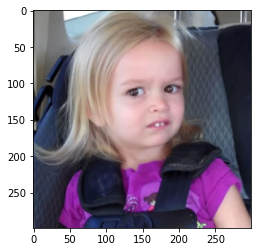

a young girl is smiling while holding a cell phone .
a young girl is sitting in a chair with a cell phone .
a young girl is holding a cell phone in her hand .
a young girl is sitting in a chair with a cell phone .
a young child is eating a piece of pizza .
a young girl is sitting on a chair with her cell phone .
a young girl is smiling while holding a cell phone .
a young girl is holding a cell phone in her hand .
a young girl is sitting in a chair eating a piece of cake .
a young child is sitting in a chair .


In [38]:
print_captions('girl.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


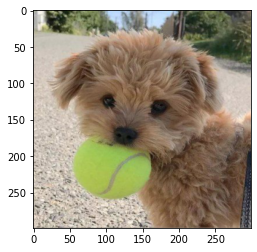

a small dog is playing with a ball .
a dog is on a tennis court with a racket .
a dog is standing on a tennis court .
a dog is standing on a tennis court .
a dog is holding a tennis racket in a field .
a dog is playing with a tennis ball
a dog is holding a tennis racket in a field .
a small dog is standing on a tennis court .
a dog is standing on a tennis court .
a dog is on a tennis court with a racket .


In [40]:
print_captions('dog_ball.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


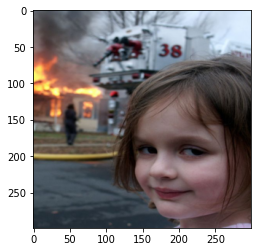

a young child is eating a piece of pizza .
a young boy eating a piece of pizza .
a little girl eating a piece of food .
a young child is holding a teddy bear .
a little girl in a red shirt is holding a cell phone .
a young boy is eating a piece of pizza .
a young boy is eating a piece of food .
a young boy is eating a piece of pizza .
a child is holding a teddy bear in her hand .
a young boy is sitting at a table with a cake .


In [41]:
print_captions('fire_girl.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


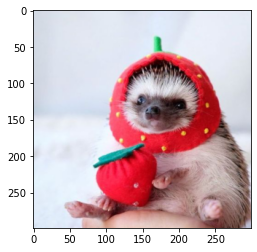

a dog is sitting on a chair with a teddy bear .
a dog is sitting on a chair with a toy .
a dog is laying on a green chair .
a dog is sitting on a chair in a room .
a brown and white dog laying on a green couch .
a dog is sitting on a chair with a toy .
a brown dog sitting on a table with a banana in its mouth .
a dog laying on the ground with a remote control .
a dog is sitting on a chair with a toy .
a dog is sitting on a chair with a toy .


In [42]:
print_captions('hedgehog_berry.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


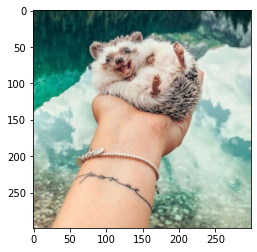

a woman holding a dog with a frisbee in his mouth .
a couple of cats are laying on the ground .
a man holding a white frisbee in his mouth .
a woman holding a dog in a small white frisbee .
a small dog laying on the ground with a frisbee in its mouth .
a small cat is laying on the ground .
a small dog is laying on the ground with a frisbee in its mouth .
a woman holding a dog on a leash in a field .
a woman holding a dog in her mouth on a beach .
a woman holding a dog in a yellow shirt .


In [43]:
print_captions('hedgehog.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


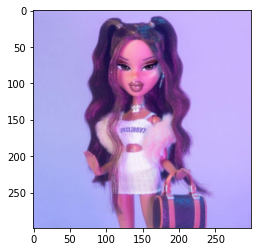

a woman in a dress shirt and tie holding a teddy bear .
a woman in a dress shirt and tie is holding a teddy bear .
a woman with a red hair and a teddy bear .
a woman standing in front of a cake with a teddy bear .
a woman holding a teddy bear on her head .
a woman with a red hair and a teddy bear .
a woman is sitting on a bed with her teddy bear .
a woman and a child are sitting on a bed .
a woman wearing a red jacket and a red tie .
a woman in a dress shirt and a dog on a bed .


In [44]:
print_captions('bratz.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


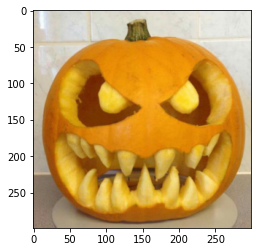

a white and black dog laying on a bed .
a white and black dog laying on a bed .
a white and white dog laying on a bed .
a white and black cat laying on a white plate .
a white and black dog laying on a bed .
a close up of a dog on a bed
a white and white dog with a bag of shoes .
a white and white dog laying on a bed .
a white and black dog laying on a bed .
a pair of scissors on a table with a knife and a bottle of wine .


In [45]:
print_captions('pumpkin.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


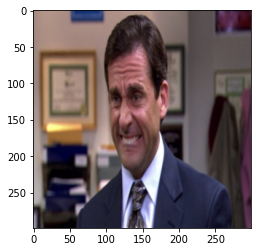

a man in a suit and tie in a suit .
a man wearing a suit and tie in a room
a man wearing a suit and tie
a man wearing a suit and tie .
a man in a suit and tie with a tie .
a man wearing a suit and tie with a tie .
a man wearing a suit and tie in a room .
a man wearing a suit and tie .
a man wearing a suit and tie holding a white tie .
a man with a tie and a tie .


In [46]:
print_captions('michael.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


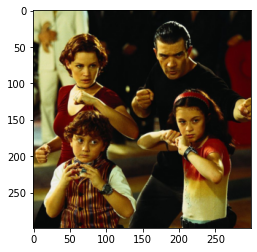

a group of people eating a meal in a room .
a group of people eating food in a room .
a group of people eating a meal in a large room .
a man and a woman eating a doughnut .
a group of people eating a meal in a room .
a group of people eating a meal in a room .
a group of people eating a meal in a room .
a group of people eating a meal at a party .
a group of people eating a meal at a table .
a group of people eating a meal at a table .


In [47]:
print_captions('spy_kids.jpg')

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563